
### Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.


### 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  

In [65]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import scipy.stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
%matplotlib inline 

Load the data and see the first rows to check the table.

In [66]:
SeaIce = pd.read_csv('SeaIce.txt', delim_whitespace = True)
SeaIce.head(10)

,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92
5,1984,1,Goddard,N,14.61,11.60
6,1985,1,Goddard,N,14.86,11.60
7,1986,1,Goddard,N,15.02,11.79
8,1987,1,Goddard,N,15.20,11.81
9,1988,1,-9999,N,-9999.00,-9999.00


Check if have a "na" parameters.

In [67]:
SeaIce.isna().sum()

year         0
mo           0
data_type    0
region       0
extent       0
area         0
dtype: int64

Check the most important metrics of the numeric variables to detect possible outliers:

In [68]:
SeaIce.describe()

,year,mo,extent,area
count,424.000000,424.000000,424.000000,424.000000
mean,1996.000000,6.500000,-35.443066,-37.921108
std,10.214716,3.474323,686.736905,686.566381
min,1978.000000,1.000000,-9999.000000,-9999.000000
25%,1987.000000,3.000000,9.272500,6.347500
50%,1996.000000,6.500000,12.385000,9.895000
75%,2005.000000,10.000000,14.540000,12.222500
max,2014.000000,12.000000,16.450000,13.840000


As see in the table, I detect in variables extent and area a min and mean metrics that there are negative. This variables should be greater or equal than zero. Clean the data and check again:

In [69]:
SeaIce = SeaIce.loc[SeaIce['area'] >= 0]
SeaIce.describe()

,year,mo,extent,area
count,422.000000,422.000000,422.000000,422.000000
mean,1996.040284,6.500000,11.777583,9.287796
std,10.222038,3.461872,3.120722,3.180044
min,1978.000000,1.000000,3.630000,2.150000
25%,1987.000000,3.250000,9.360000,6.382500
50%,1996.000000,6.500000,12.395000,9.990000
75%,2005.000000,9.750000,14.560000,12.227500
max,2014.000000,12.000000,16.450000,13.840000


Check the no numeric variables:

In [70]:
SeaIce['data_type'].unique()

array(['Goddard', 'NRTSI-G'], dtype=object)

In [71]:
SeaIce['region'].unique()

array(['N'], dtype=object)

Now, all is correct to work with the dataset.

### 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

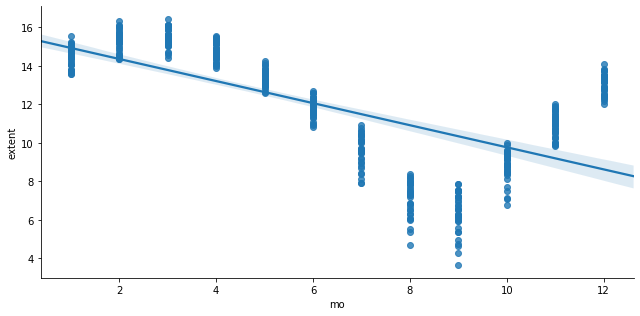

In [72]:
#your response here
sns.lmplot(x = 'mo', y = 'extent', data = SeaIce,  height=4.5, aspect = 2)

lmplot is used to see the montly dependence of SIE. 

Next, compute the mean and variance:

In [73]:
SIE_mean = SeaIce.groupby('mo', as_index= False)['extent'].mean()
SIE_mean

,mo,extent
0,1,14.479429
1,2,15.298889
2,3,15.491714
3,4,14.766000
4,5,13.396000
5,6,11.860000
6,7,9.601143
7,8,7.122286
8,9,6.404857
9,10,8.809143


In [74]:
SIE_var = SeaIce.groupby('mo', as_index= False)['extent'].var()
SIE_var

,mo,extent
0,1,0.304906
1,2,0.295804
2,3,0.237209
3,4,0.215378
4,5,0.189901
5,6,0.247918
6,7,0.679175
7,8,0.824577
8,9,1.143902
9,10,0.630361


Normalize the SIE data: subtract the monthly mean and then convert to percent difference by dividing by the monthly mean and then multiplying by 100. Use the normalized SIE for the rest of the exercise.

In [75]:
SeaIce = pd.merge(SeaIce, SIE_mean, on = 'mo')

In [76]:
SeaIce['extent'] = ((SeaIce['extent_x']-SeaIce['extent_y'])/SeaIce['extent_y'].mean())*100

In [77]:
SeaIce = SeaIce[['year', 'mo', 'data_type', 'extent', 'area']]
SeaIce

,year,mo,data_type,extent,area
0,1979,1,Goddard,9.005001,12.33
1,1980,1,Goddard,4.080391,11.85
2,1981,1,Goddard,4.674740,11.82
3,1982,1,Goddard,6.627603,12.11
4,1983,1,Goddard,5.269090,11.92
...,...,...,...,...,...
417,2009,12,Goddard,-4.665037,10.25
418,2010,12,Goddard,-8.825483,10.08
419,2011,12,Goddard,-5.599014,10.28
420,2012,12,Goddard,-7.297156,10.11


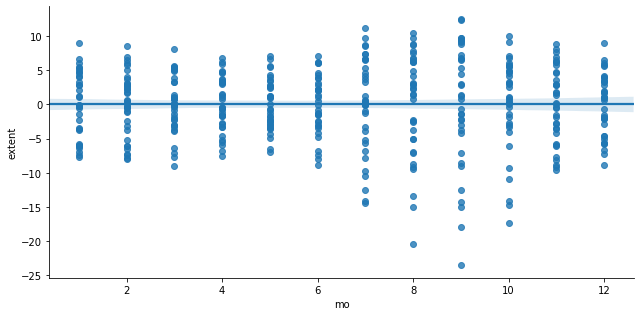

In [78]:
sns.lmplot(x = 'mo', y = 'extent', data = SeaIce,  height=4.5, aspect=2)

Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

Visualize the trend of SIE per year:

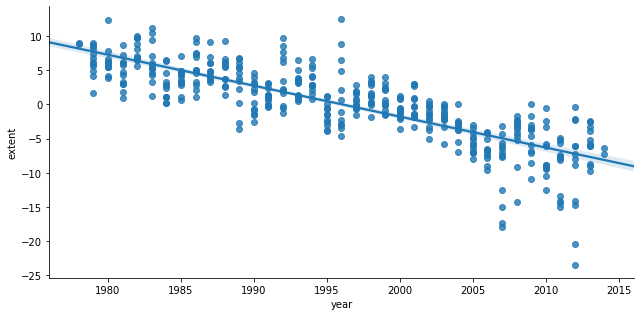

In [79]:
sns.lmplot(x = 'year', y = 'extent', data = SeaIce,  height=4.5, aspect=2)

Visualize the trend of SIE January:

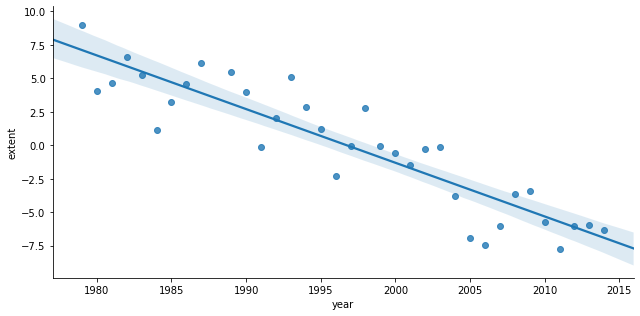

In [80]:
SeaIce_january = SeaIce.loc[SeaIce['mo']==1]
sns.lmplot(x = 'year', y = 'extent', data = SeaIce_january,  height=4.5, aspect=2)

Visualize the trend of SIE August:

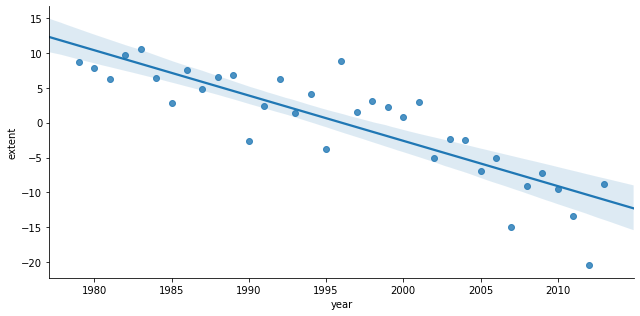

In [81]:
SeaIce_august = SeaIce.loc[SeaIce['mo']==8]
sns.lmplot(x = 'year', y = 'extent', data = SeaIce_august,  height=4.5, aspect=2)

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

In [82]:
scipy.stats.pearsonr(SeaIce['year'].values, SeaIce['extent'].values)

(-0.8183500709897177, 4.4492318168708476e-103)

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

In [83]:
x = SeaIce[['year']]
y = SeaIce[['extent']]
model = LinearRegression()
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

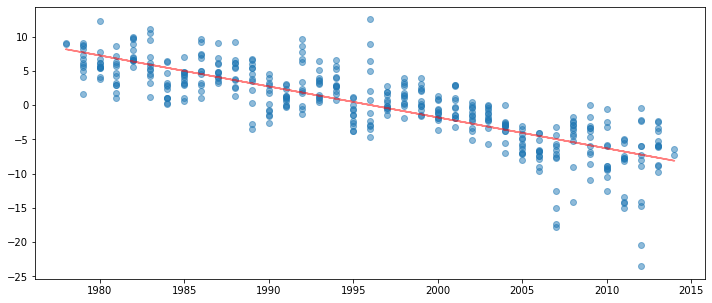

In [84]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))
plt.plot(x, y, 'o',alpha = 0.5)
plt.plot(x, model.predict(x),'r', alpha= 0.5)
plt.show()

We extract the metrics to evaluate the model:

In [85]:
print('Coeff and intercept:', model.coef_, model.intercept_)
print('Score:', model.score(x,y)) 
print('MSE: ', np.mean((model.predict(x) - y)**2))

Coeff and intercept: [[-0.45250669]] [903.22158262]
Score: 0.6696968386888766
MSE:  extent    10.527594
dtype: float64


### 4. Estimate the sea ice extent for January 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

To obtain the prediction, we must reverting the normalization proces to return to original value:

In [86]:
year_predict = [[2025]]
pred_2025 = ((model.predict(year_predict)*SIE_mean['extent'].mean())/100) + SIE_mean[SIE_mean['mo']==1]['extent'].sum()

In [87]:
print(f"Prediction to January 2025 is {pred_2025}")

Prediction to January 2025 is [[12.93688439]]
